In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)
from stock_utils import *

C:\Users\adity\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\adity\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\adity\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
def RSI(series, period):
    
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = pd.DataFrame.ewm(u, com=period-1, adjust=False).mean() / \
         pd.DataFrame.ewm(d, com=period-1, adjust=False).mean()
    
    return 100 - 100 / (1 + rs)


def rsi_class(x):
    ret = "low"
    if x < 50:
        ret = "low"
    if x > 50:
        ret = "med"
    if x > 70:
        ret = "high"
    return(ret)

In [3]:
from datetime import datetime
tech_list = ['AAPL', 'GOOG', 'AMZN']

start = "2010-01-01"
end = datetime.now()
for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)
    
company_list = [AAPL, GOOG, AMZN]
company_name = ["APPLE", "GOOGLE", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)
df.head(10)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.515212,493729600,APPLE
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.526477,601904800,APPLE
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.422665,552160000,APPLE
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.410791,477131200,APPLE
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.453411,447610800,APPLE
2010-01-11,7.600000,7.607143,7.444643,7.503929,6.396482,462229600,APPLE
2010-01-12,7.471071,7.491786,7.372143,7.418571,6.323722,594459600,APPLE
2010-01-13,7.423929,7.533214,7.289286,7.523214,6.412922,605892000,APPLE
2010-01-14,7.503929,7.516429,7.465000,7.479643,6.375781,432894000,APPLE


In [22]:
n_lookback = 500
n_forecast = 60
df_stock = AMZN.reset_index().copy()

In [23]:
df_stock, df_left = create_backtest_frames(df_stock,n_lookback,n_forecast)

In [24]:
df_stock = feature_creation(df_stock)

In [25]:
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3231 entries, 0 to 3230
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          3231 non-null   datetime64[ns]
 1   Open          3231 non-null   float64       
 2   High          3231 non-null   float64       
 3   Low           3231 non-null   float64       
 4   Close         3231 non-null   float64       
 5   Adj Close     3231 non-null   float64       
 6   Volume        3231 non-null   int64         
 7   company_name  3231 non-null   object        
 8   50D-SMA       3182 non-null   float64       
 9   50D-EMA       3231 non-null   float64       
 10  rsi           3217 non-null   float64       
 11  rsicat        3231 non-null   int8          
 12  average       3231 non-null   float64       
 13  vwap          3231 non-null   float64       
 14  vwap_pct_ret  3230 non-null   float64       
 15  pvwap         3230 non-null   float64 

In [26]:
df_stock.bfill(inplace=True)
df_stock.ffill(inplace=True)

In [27]:
#df_left = df_stock.iloc[:-100]
df_stock.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,company_name,50D-SMA,50D-EMA,rsi,rsicat,average,vwap,vwap_pct_ret,pvwap
3226,2022-10-26,116.000000,119.349998,114.760002,115.660004,115.660004,68802300,AMAZON,123.0188,120.415688,46.500584,1,116.590001,115.660004,-0.040962,-0.040636
3227,2022-10-27,113.919998,114.120003,109.769997,110.959999,110.959999,129605400,AMAZON,122.3960,120.044877,40.609601,1,111.616666,110.959999,-0.040636,-0.068042
3228,2022-10-28,97.910004,103.959999,97.660004,103.410004,103.410004,223133400,AMAZON,121.6182,119.392529,33.309477,1,101.676669,103.410004,-0.068042,-0.009380
3229,2022-10-31,103.559998,104.870003,100.739998,102.440002,102.440002,99251400,AMAZON,120.9024,118.727724,32.501108,1,102.683334,102.440002,-0.009380,-0.055154
3230,2022-11-01,103.989998,104.580002,96.059998,96.790001,96.790001,153370000,AMAZON,120.1738,117.867421,28.207111,1,99.143333,96.790001,-0.055154,-0.055154


In [28]:
df_left.head()

,Date,Open,High,Low,Close,Adj Close,Volume,company_name
3231,2022-11-02,97.320000,97.739998,92.010002,92.120003,92.120003,135761800,AMAZON
3232,2022-11-03,92.470001,93.500000,89.019997,89.300003,89.300003,136683300,AMAZON
3233,2022-11-04,91.489998,92.440002,88.040001,90.980003,90.980003,129101300,AMAZON
3234,2022-11-07,91.949997,92.099998,89.040001,90.529999,90.529999,77495700,AMAZON
3235,2022-11-08,90.790001,91.720001,88.230003,89.980003,89.980003,88703400,AMAZON


In [11]:
# Removing last n rows
#df_dropped_last_n = df.iloc[:-100]
 

In [12]:
df_stock.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'company_name', '50D-SMA', '50D-EMA', 'rsi', 'rsicat', 'average',
       'vwap', 'vwap_pct_ret', 'pvwap'],
      dtype='object')

In [29]:
features = ['Close','50D-SMA','50D-EMA','rsi','vwap']
x = df_stock[features]
scaler = MinMaxScaler(feature_range=(0, 1))
x = scaler.fit_transform(x)

In [30]:
y = df_stock['Close'].fillna(method='ffill')
y = y.values.reshape(-1, 1)

# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

In [31]:
f_len = len(features)

In [32]:
%run stock_utils.py
a,b = create_train_test_windows(x,y,n_lookback,n_forecast)
stock_model = create_model(n_lookback,n_forecast,f_len,model_type='LSTM')
stock_model.fit(a, b, epochs=3, batch_size=32)


Epoch 1/3
84/84 [==============================] - 42s 500ms/step - loss: 0.0375
Epoch 2/3
84/84 [==============================] - 49s 587ms/step - loss: 0.0030
Epoch 3/3
84/84 [==============================] - 50s 593ms/step - loss: 0.0026


In [ ]:
#stock_model = tf.keras.models.load_model('saved_models/AAPL_7day_model')

In [33]:
%run stock_utils.py
df_f,df_p = make_future_dataframe(df_stock,x,y,n_lookback,n_forecast,stock_model,scaler,features,f_len)

In [ ]:
df_p.tail()

In [ ]:
df_f.head()

In [ ]:
df_left.head()

In [ ]:
import matplotlib.pyplot as plt
df_left['Forecast'] = df_f['Forecast']
df_left.plot(x='Date',y=['Forecast','Close'])

In [34]:
rmse = np.sqrt(np.mean(((np.array(df_f['Forecast'])- np.array(df_left['Close'])) ** 2)))
rmse

26.998868330242665

In [35]:
from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error
print(mean_absolute_percentage_error(np.array(df_left['Close']), np.array(df_f['Forecast'])))
print(mean_absolute_error(np.array(df_left['Close']), np.array(df_f['Forecast'])))

0.292809781361314
26.505560811360677


In [39]:
#stock_model.save('saved_models/AMZN_30day_model')
stock_model = tf.keras.models.load_model('saved_models/AMZN_30day_model')

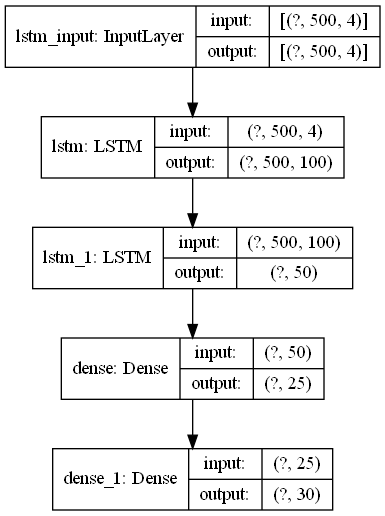

In [40]:
ifile = 'model_archs/AMZN_30day_model.png'
tf.keras.utils.plot_model(stock_model, to_file = ifile, show_shapes = True, show_layer_names = True)

In [ ]:
#df = df.reset_index()

In [ ]:
#df_Actual = df.loc[(df['Date']>='2022-08-23')&(df['Date']<='2022-10-11')]

In [ ]:
#df_Actual.head(36)

In [ ]:
#new_df = pd.merge(df_Actual, df_future,  how='inner',on='Date')

In [ ]:
#new_df.head(36)

In [ ]:
#df_future = df_future[df_future.Date.dt.weekday < 5]

In [ ]:
#from sklearn.metrics import mean_squared_error
#mean_squared_error(np.array(new_df['Close']),np.array(new_df['Forecast']))
#df_future.head(5)

In [ ]:
#df_Actual.shape

In [ ]:
#rmse = np.sqrt(np.mean(((np.array(df_future['Forecast'])- np.array(df_Actual['Close'])) ** 2)))
#rmse

In [ ]:
#results = df_past.append(df_future).set_index('Date')

# plot the results
#results.plot(title='AAPL')